My Architecture and Algorithms:
- build Sequential CNN
- 2 Dense layers
- Elu or Relu (research difference, both should work)
- kernel_initializer = "he_normal"
- Regular batch normalization and max pooling and drop out
- Flatten towards the end of the CNN
- (3,3) kernel sizes for convolution layers
- Softmax final activation function
- Batch size between 26-64 -> try 32 ?
- Loss: categorical cross-entropy
- Early stopping based on val_accuracy
- Maybe ReduceLROnPlateau
- Resize images(divide by 255)
- 48x48x1 size for input images

## Importing necessary libraries

In [1]:
from pathlib import Path

import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras.utils

Uploading the dataset from my folders

To be run, the dataset must be downloaded and moved to the same directory of this notebook. The dataset can be found here: https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge

In [4]:
df = pd.read_csv('fer2013.csv')
print(df.shape)

df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Mapping the numerical representation of each emotion to its verbal label

In [314]:
emotion_label_to_text = {
  0: 'anger',
  1: 'disgust',
  2: 'fear',
  3: 'happiness',
  4: 'sadness',
  5: 'surprise',
  6: 'neutral'
}

Visualizing the distribution of emotions within the dataset

/Users/amandachiang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


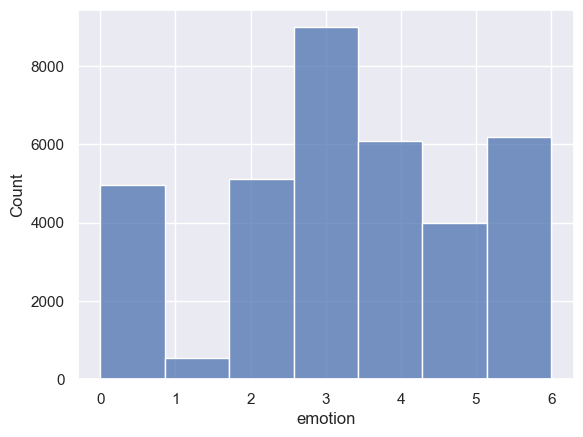

In [315]:
bins = df.emotion.nunique()

sns.histplot(df.emotion,x=df.emotion,bins=bins)
pyplot.show()

Using pyplot to preview the dataset in rows sorted by the emotion they depict

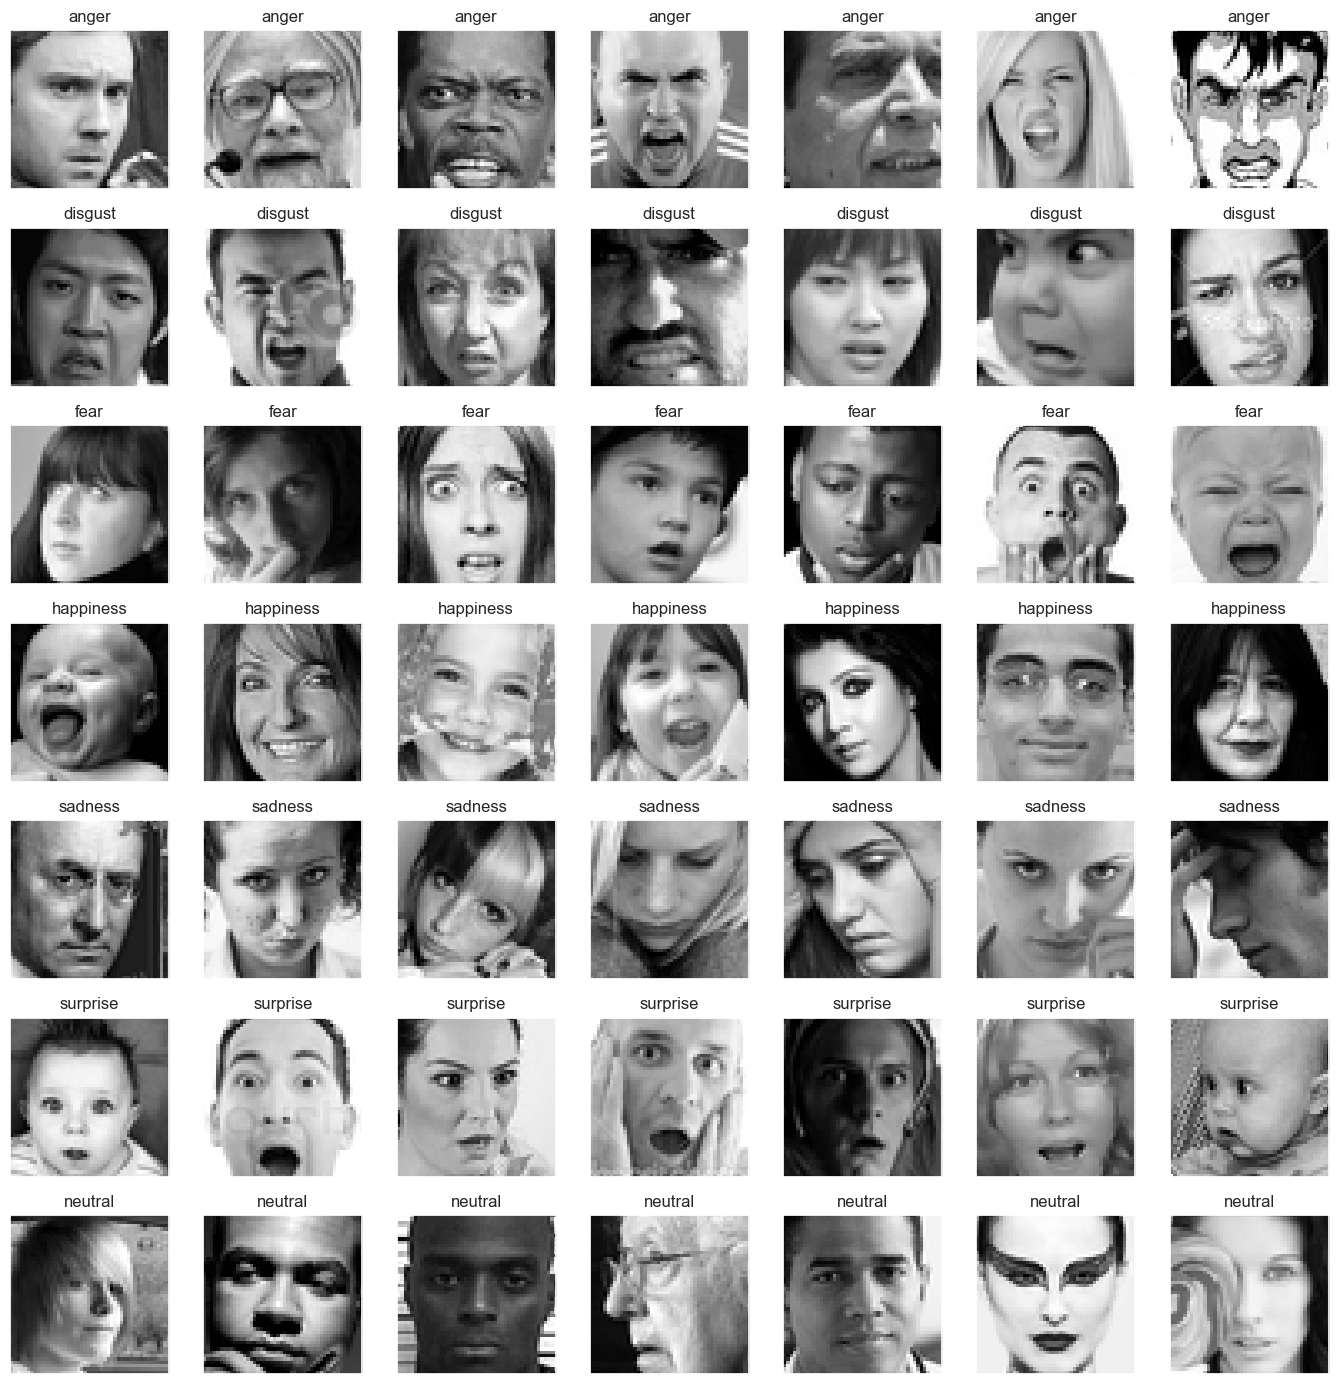

In [316]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(bins):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

Resizing the images to be a uniform size that is compatible with our CNN model (48x48x1). This helps with consistency and speed (shrinking images down so that each process takes less time)

The image size is 48x48 and the 1 references the color channels. Since we are making each image grayscale, we only need 1 channel rather than 3

In [317]:
# current data not in the format that's compatible with our CNN model (48x48x1)

img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')) # convert each flattened image into a square 3 dimensional image of size 48x48x1
img_array = np.stack(img_array, axis=0) # stacked all those images along the 4th dimension to feed into model as one batch. This is because we will be using mini-batch gradient descent as the optimizer
img_array.shape #

# label encoding the categories
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = keras.utils.to_categorical(img_labels)
img_labels.shape # (21264, 3)


# mapping from original class labels to new class labels
# this is more helpful if you remove emotions from the original dataset to connect them to their new indexes
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_))) 
le_name_mapping 

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

Splitting into test and training data with a 90/10 split + some housekeeping items

In [318]:
X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True, 
  stratify=img_labels,
  test_size=0.1, 
  random_state=42
)

del df
del img_array
del img_labels

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(32298, 48, 48, 1) (3589, 48, 48, 1) (32298, 7) (3589, 7)


Using min-max normalization because neural networks are very sensitive to unnormalized data

At the same time, we preserve the relationships that are important to analyzing each image

In [319]:
X_train = X_train / 255.
X_valid = X_valid / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

**Building the custom Sequential CNN**

Based on existing projects' CNN architecture, I incorporated
- regular dropouts, max pooling, and batch normalization
- he_normal kernal initializer
- softmax activation function
- varying filter size convolution layers
- categorical cross entropy loss

Using Elu activation function because, unlike ReLU, it doesn't have the dying relu problem. I've seen both Elu and ReLU used in existing proejcts. Moreover, nearly every project seems to use he_normal for the kernel_initializer and softmax for the final activation function. 

Using regular rounds of Batch Normalization, Dropout, and Pooling. Batch normalization and Max Pooling used to keep data normalized and small, to be better formatted for the CNN. Dropout used to prevent overfitting by randomly nullifying the contributions of some neurons.

In [320]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64, 
            kernel_size=(3,3),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same', # what is same ?
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1')) # used after each layer to normalize the recently added layer
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

Callbacks to adjust the model's training to help with overfitting and excessive training

I'm using the following:
- Early Stopping to prevent overfitting and wasting time on additional training when there aren't enough increases in accuracy
- ReduceLROnPlateau to reduce the learning rate when validation accuracy plateaus

Both callbacks I used after seeing them in multiple existing FER projects


In [321]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

Using ImageDataGenerator to help model performance by: 

- Creating more training images by distorting / transforming each image
- Creating more noise / preventing the model from memorizing backgrounds of each image

In [322]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

## Building the Model

Parameters that I played with for performance on different models, results and trials recorded below.

Tried both Nadam and Adam optimizers, as I have seen both of them in existing projects

In [323]:
batch_size = 32 #batch size of 32 performs the best.

# 20 epochs yielded ~0.6 accuracy. So definitely need more
epochs = 100

optims = [
    #optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.legacy.Adam(0.001)#,
]

In [ ]:
model_6 = build_net(optims[0]) 

history = model_6.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=False
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

/var/folders/n2/ncskglln6r17v07k20cqjwx40000gn/T/ipykernel_63273/2773232660.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_6.fit_generator(


1009/1009 [==============================] - 299s 296ms/step - loss: 1.9993 - accuracy: 0.2419 - val_loss: 1.6596 - val_accuracy: 0.3288 - lr: 0.0010
Epoch 2/100
1009/1009 [==============================] - 317s 314ms/step - loss: 1.6259 - accuracy: 0.3572 - val_loss: 1.3710 - val_accuracy: 0.4851 - lr: 0.0010
Epoch 3/100
1009/1009 [==============================] - 333s 330ms/step - loss: 1.4503 - accuracy: 0.4417 - val_loss: 1.3375 - val_accuracy: 0.4954 - lr: 0.0010
Epoch 4/100
1009/1009 [==============================] - 342s 339ms/step - loss: 1.3579 - accuracy: 0.4826 - val_loss: 1.1976 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 5/100
1009/1009 [==============================] - 347s 344ms/step - loss: 1.2946 - accuracy: 0.5092 - val_loss: 1.1353 - val_accuracy: 0.5712 - lr: 0.0010
Epoch 6/100
1009/1009 [==============================] - 816s 808ms/step - loss: 1.2160 - accuracy: 0.5430 - val_loss: 1.1397 - val_accuracy: 0.5617 - lr: 0.0010
Epoch 8/100
1009/1009 [=================

## Analyzing Results

Using Seaborn to graph accuracy and loss throughout increasing epochs in both the training and test datasets. For most models, I saw inverse elbow & elbow shapes for accuracy and loss (respectively) as expected

/Users/amandachiang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amandachiang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amandachiang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amandachiang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

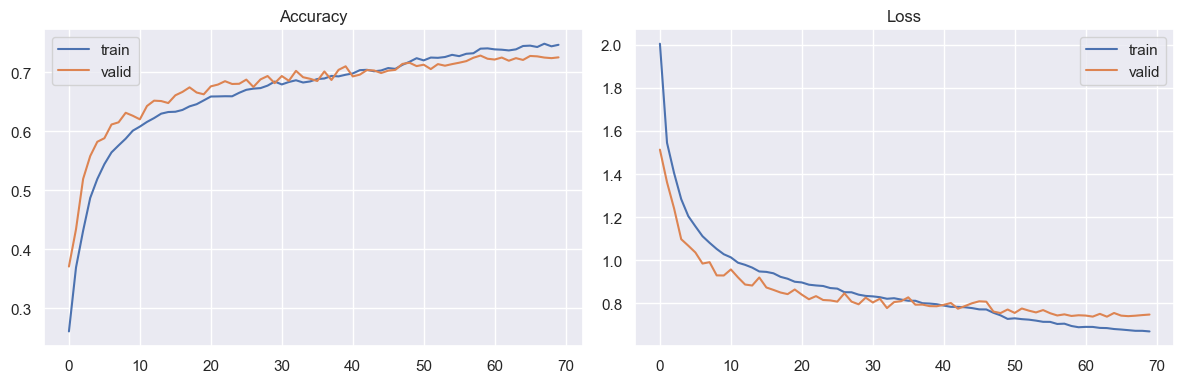

In [69]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

Using Seaborn for a violin plot to visualize the spread / distribution of the data and their corresponding accuracy and loss values for both the training and test datasets

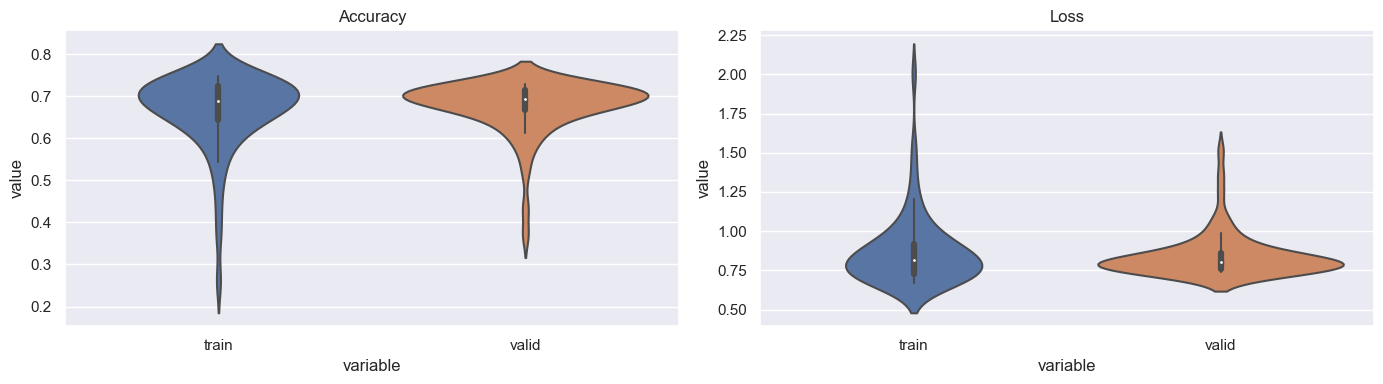

In [70]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

Using Scikit to generate performance reports with metrics such as precision, recall, f1-score, and support for each emotion as well as overall metrics.

The Confusion Matrix is also very helpful in understanding the type of predictions the model makes and whether or not that is preferable. For example, I can learn that my model often fails to detect certain emotions (more false negatives).

Because my project is detecting emotions for mental health, I would prefer false positives (which prompts pop-ups that the user can just ignore) versus false negatives (where the user is lacking the resources needed)

My preference for false positives over false negatives also led me to weigh recall more in my analyses

93/93 [==============================] - 10s 105ms/step
total wrong validation predictions: 806


              precision    recall  f1-score   support

           0       0.61      0.64      0.62       495
           1       0.79      0.49      0.61        55
           2       0.59      0.47      0.53       512
           3       0.90      0.91      0.90       899
           4       0.64      0.75      0.69       608
           5       0.78      0.77      0.77       400

    accuracy                           0.73      2969
   macro avg       0.72      0.67      0.69      2969
weighted avg       0.73      0.73      0.73      2969



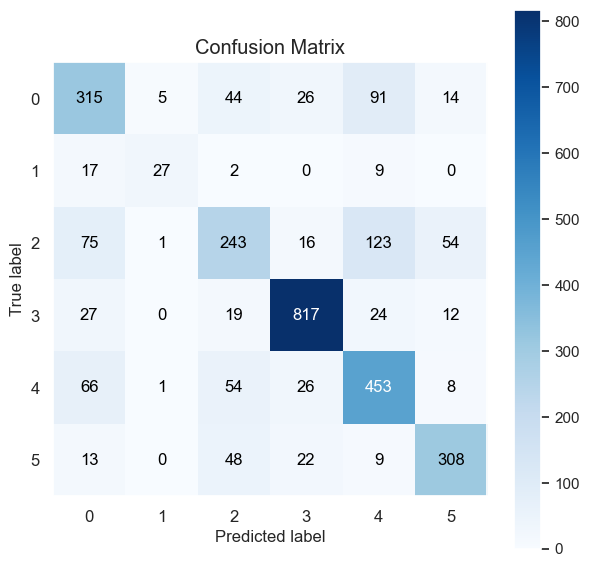

In [71]:
predict_x=model_4.predict(X_valid) 
classes_x_valid=np.argmax(predict_x,axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), classes_x_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != classes_x_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), classes_x_valid))

**Recording results from different models with my custom CNN architecture but with different parameters**

5th model settings:
- 100 epochs
- (3,3) kernel size for first two convolution layers
- loss: Categorical cross-entropy
- Optimizer: Adam
- batch size: 64
- elu

Results: early stopped at epoch 80 with accuracy: 0.7085, val_accuracy: 0.6957

In [311]:
%store model_5

Stored 'model_5' (Sequential)


4th model - 100 epochs, batch size 64, updated the dataset with earlier lines of code, Nadam optimizer. accuracy - 0.7468.

Graphs make more sense

In [68]:
%store model_4

Stored 'model_4' (Sequential)


3rd model - 100 epochs, batch size 64 -- early stopping at epoch 28, accuracy 0.7

In [36]:
%store model_3

Stored 'model_3' (Sequential)


Storing the first 100 epoch training which early stopped at epoch 68

In [18]:
%store model_2

Stored 'model_2' (Sequential)


Storing the first model with 20 epochs

In [34]:
%store model

Stored 'model' (Sequential)


Part of my earlier experimentation with saving models in Jupyter notebooks and Tensorflow

In [31]:
from tensorflow.keras.models import load_model

# Saving the model as '20_epoch_model'
model.save('20_epoch_model')

# Can be loaded with:
# model = load_model('model.h5')

INFO:tensorflow:Assets written to: 20_epoch_model/assets


INFO:tensorflow:Assets written to: 20_epoch_model/assets


In [33]:
# Demonstrating loading the model
model2 = load_model('20_epoch_model')

model2.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

### Result Reports

Results of 3rd 100 epoch model training with:
- Base architecture
- Batch size: 64
- Optimizer: Nadam
- Actually removed Neutral emotion - re-ran data pre-processing cells
- Early Stopping and ReduceLROnPlateau

Early Stopped at epoch 70 with accuracy 0.7468.
- Anger: 0.61 precision, 0.64 recall
- Disgust: 0.79 precision, 0.49 recall
- Fear: 0.59 precision, 0.47 recall
- Happiness:0.90 precision, 0.91 recall
- Sadness: 0.64 precision, 0.75 recall
- Surprise: 0.78 precision, 0.77 recall

Results still not good enough, need higher recall for all emotions other than happiness. Definitely need more data for those other columns, as Happiness seems to have over double that of the other columns

Results of second 100 epoch training with:
- Base architecture
- Batch size: 64
- Optimizer: Adam
- "removed Neutral emotion"
- Early Stopping and ReduceLROnPlateau

Early Stopping kicked in at epoch 28 with accuracy 0.7 BUT WEIRD BEHAVIOR: only ever predicted surprise ?? Figure out why. Surprise has 0.95 recall but 0.11 precision

* Note: I forgot to re-run earlier lines of code after updating df, could have impacted results

Results of running first 100 epoch training with:
- Base Architecture
- Batch size: 32
- Optimizer: Adam
- Early Stopping and ReduceLROnPlateau

Early stopping kicked in at epoch 68. Accuracy only reached 0.7. I'll use recall to measure the performance because false negatives are worse than false positives in my case. Resulting recall for each emotion:
- Anger: 0.66
- Disgust: 0.47
- Fear: 0.43
- Happiness: 0.88
- Sadness: 0.58
- Surprise: 0.80
- Neutral: 0.75

This is bad because, given my application, we want the model to be best at recognizing Anger, Disgust, Fear, and Sadness. 

In [44]:
emotion_label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

I'm going to be dropping the emotion "neutral" as it is not relevant for my application

In [31]:
df.shape

(35887, 3)

In [279]:
INTERESTED_LABELS = [0, 1, 2, 3, 4, 5]

df = df[df.emotion.isin(INTERESTED_LABELS)]

df.shape

(29689, 3)

## Transfer Learning Experimentation

Switching from my custom Sequential model to using existing VGG19, as I saw was successful in an existing project with the same dataset https://www.kaggle.com/code/milan400/fer2013-facial-expression-detection

In [280]:
from keras.applications.vgg19 import VGG19

vgg_conv = VGG19(weights=None, include_top=False, input_shape=(48, 48,1))

### Building the model

In [281]:
from keras.optimizers import SGD,RMSprop,adam, Adadelta

def vgg_custom():
    model = Sequential()
    #add vgg conv model
    model.add(vgg_conv)
    
    #add new layers
    model.add(Flatten())
    model.add(Dense(7,  kernel_initializer='he_normal'))
    model.compile(loss='mean_squared_error', optimizer="RMSprop", metrics=['accuracy'])
    #model.compile(loss='mean_squared_error', optimizer="adam")
    #model.compile(loss='mean_squared_error', optimizer=RMSprop())
    
    return model

Re-defining some parameters

In [282]:
epochs = 100
batch_size = 64

In [283]:
vgg_model2 = vgg_custom()
vgg_model2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20023232  
                                                                 
 flatten_15 (Flatten)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 20026823 (76.40 MB)
Trainable params: 20026823 (76.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [284]:
history = vgg_model2.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs, verbose=1,
    callbacks = callbacks 
    ,shuffle = True
    )

Epoch 1/100


/var/folders/n2/ncskglln6r17v07k20cqjwx40000gn/T/ipykernel_63273/1803063746.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg_model2.fit_generator(


504/504 [==============================] - 735s 1s/step - loss: 4.6159 - accuracy: 0.2465 - val_loss: 0.1183 - val_accuracy: 0.2505 - lr: 0.0010
Epoch 2/100
504/504 [==============================] - 772s 2s/step - loss: 0.1182 - accuracy: 0.2500 - val_loss: 0.1184 - val_accuracy: 0.2505 - lr: 0.0010
Epoch 3/100
504/504 [==============================] - 761s 2s/step - loss: 0.1182 - accuracy: 0.2505 - val_loss: 0.1182 - val_accuracy: 0.2505 - lr: 0.0010
Epoch 4/100
504/504 [==============================] - 748s 1s/step - loss: 0.1182 - accuracy: 0.2505 - val_loss: 0.1182 - val_accuracy: 0.2505 - lr: 0.0010
Epoch 5/100
504/504 [==============================] - 750s 1s/step - loss: 0.1182 - accuracy: 0.2505 - val_loss: 0.1182 - val_accuracy: 0.2505 - lr: 0.0010
Epoch 6/100
504/504 [==============================] - 751s 1s/step - loss: 0.1182 - accuracy: 0.2505 - val_loss: 0.1182 - val_accuracy: 0.2505 - lr: 0.0010
Epoch 7/100
504/504 [==============================] - 777s 2s/step - 

(I re-used the graphs and reports from earlier in the notebook to analyze the performance, that's why there's no more code here)

### Result Reports

Clearly, I implemented something wrong, as my results don't completely make sense

Settings for forth model with VGG19:
- VGG19 Model
- Batch size: 64
- Epochs: 100
- Early stopping and ReduceLROnPlateau
- Loss: Mean squared error
- Optimizer: RMSProp

Settings for third model with VGG19:
- VGG19 Model
- Batch size: 8
- Epochs: 100
- Early stopping and ReduceLROnPlateau
- Loss: Mean squared error
- Optimizer: RMSProp

Early stopped at epoch 12 with accuracy 0.2489

Settings for second model with VGG19:
- VGG19 Model
- Batch size: 8
- Epochs: 100
- Early stopping and ReduceLROnPlateau
- Loss: Categorical Cross entropy
- Optimizer: Adam

Early stopped at epoch 12 with accuracy 0.2505. Validation accuracy was also 0.2505

Settings for first model with VGG19:
- VGG19 Model
- Batch Size: 64
- Epochs: 100
- Early stopping and ReduceLROnPlateau
- Optimizer: Adam
- Loss: Categorical Cross-entropy

Reached 100 epochs and ended with 0.6689 accuracy. For some reason the confusion matrix isn't working. As it should, valid has more accuracy and less loss than training

In [120]:
%store vgg_model1

Stored 'vgg_model1' (Sequential)


/Users/amandachiang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amandachiang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amandachiang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amandachiang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

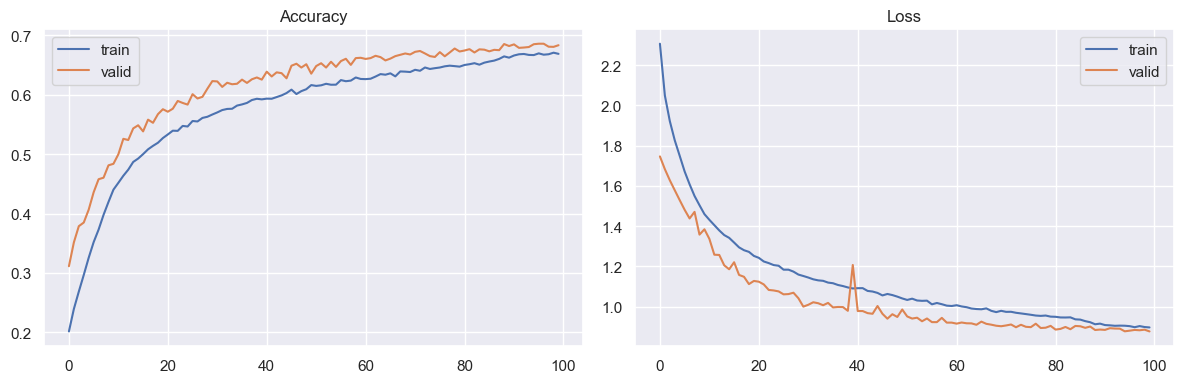

In [118]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

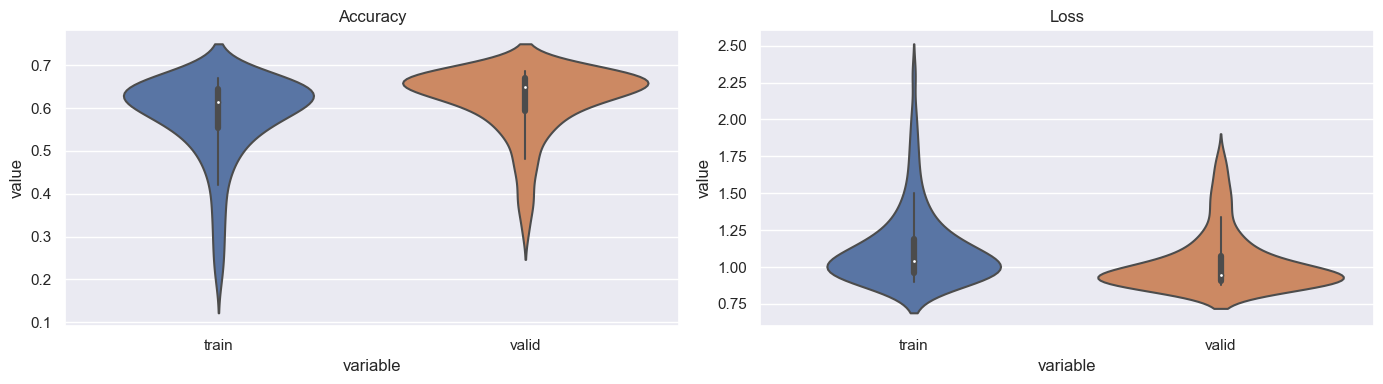

In [116]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 [==============================] - 19s 164ms/step
total wrong validation predictions: 3189


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       495
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       512
           3       0.00      0.00      0.00       899
           4       0.00      0.00      0.00       608
           5       0.11      1.00      0.20       400
           6       0.00      0.00      0.00       620

    accuracy                           0.11      3589
   macro avg       0.02      0.14      0.03      3589
weighted avg       0.01      0.11      0.02      3589



/Users/amandachiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amandachiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amandachiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


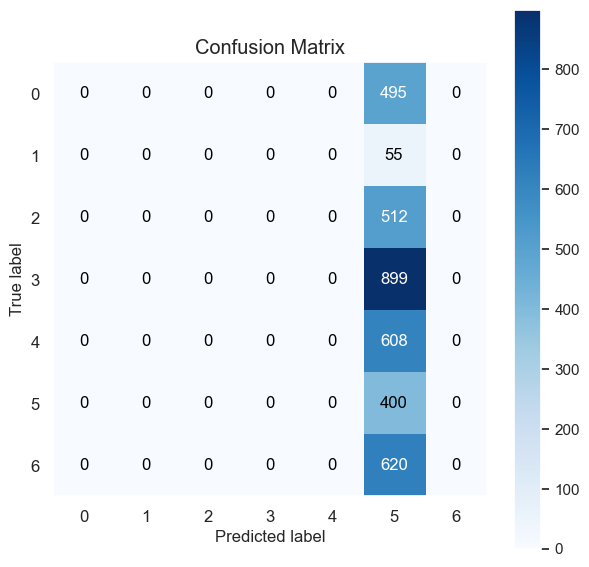

In [134]:
predict_x=vgg_model1.predict(X_valid) 
classes_x_valid=np.argmax(predict_x,axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), classes_x_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != classes_x_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), classes_x_valid))